# Assignment 5

**Submission deadlines:**

  - Tuesday/Wednesday/Friday groups: 27-30.05.2025

**Points:** Aim to get 15 out of 19 points.

EDIT (2025.05.13):

* Task 2. Added link to Wiki links.
* Task 3. Added link to data files.

## Task 1 [3p]

Implement simplified word2vec with negative sampling from scratch (using pure numpy). Assume that in the training data objects and contexts are given explicitly, one pair per line, and objects are on the left; see the [data file](https://drive.google.com/file/d/1WoBT5OrTlNnjHg6jN90RnRb7krpEzFsP/view?usp=drive_link). The result of the training should be object vectors. Please, write them to a file using *natural* text format, ie

<pre>
word1 x1_1 x1_2 ... x1_N
word2 x2_1 x2_2 ... x2_N
...
wordK xK_1 xK_2 ... xk_N
</pre>

Use the loss with negative sampling (NS) as in [Mikolov et al. 2013](https://arxiv.org/pdf/1310.4546) (see section 2.2). The loss function is as follows:
$$
 L = -\log \sigma(u_o^T v_c) - \sum_{i=1}^k \log \sigma(-u_i^T v_c);
$$
see [SKOS info](https://skos.ii.uni.wroc.pl/course/view.php?id=738#section-10) for more details.


Compute the gradient manually. You can use some gradient clipping, or regularizaton.


**Remark**: the data is specially prepared to make the learning process easier.
Present vectors using the code below. In this task we define success as 'obtaining a result which looks definitely not random'


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm

file_path = '/content/drive/MyDrive/task1_objects_contexts_polish.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    dataset = f.readlines()

dataset = dataset[:1000000]

words = set()
for line in dataset:
    parts = line.strip().split()
    if len(parts) != 2:
        continue
    word1, word2 = parts
    words.update([word1, word2])

word_to_idx = {word: idx for idx, word in enumerate(sorted(words))}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(word_to_idx)

embedding_dim = 100
learning_rate = 0.003
neg_samples = 15
epochs = 5
clip_value = 1.0

W_in = np.random.randn(vocab_size, embedding_dim) * 0.01
W_out = np.random.randn(vocab_size, embedding_dim) * 0.01

true_contexts = defaultdict(set)
for line in dataset:
    parts = line.strip().split()
    if len(parts) != 2:
        continue
    word1, word2 = parts
    true_contexts[word1].add(word2)

all_word_indices = np.array(list(range(vocab_size)))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def clip_gradients(vec, clip_value):
    norm = np.linalg.norm(vec)
    if norm > clip_value:
        return vec * (clip_value / norm)
    return vec

def train_step(center_word_idx, context_word_idx, negative_indices):
    center_vec = W_in[center_word_idx]
    context_vec = W_out[context_word_idx]

    pos_score = sigmoid(np.dot(center_vec, context_vec))
    loss_pos = -np.log(pos_score + 1e-10)

    grad_center = (pos_score - 1) * context_vec
    grad_context = (pos_score - 1) * center_vec

    grad_center = clip_gradients(grad_center, clip_value)
    grad_context = clip_gradients(grad_context, clip_value)

    W_in[center_word_idx] -= learning_rate * grad_center
    W_out[context_word_idx] -= learning_rate * grad_context

    loss_neg = 0
    for neg_idx in negative_indices:
        neg_vec = W_out[neg_idx]
        neg_score = sigmoid(np.dot(center_vec, neg_vec))
        loss_neg += -np.log(1 - neg_score + 1e-10)

        grad_center_neg = neg_score * neg_vec
        grad_neg = neg_score * center_vec

        grad_center_neg = clip_gradients(grad_center_neg, clip_value)
        grad_neg = clip_gradients(grad_neg, clip_value)

        W_in[center_word_idx] -= learning_rate * grad_center_neg
        W_out[neg_idx] -= learning_rate * grad_neg

    return loss_pos + loss_neg

for epoch in range(epochs):
    total_loss = 0
    negative_sample_table = np.random.choice(all_word_indices, size=len(dataset) * neg_samples)
    neg_sample_idx = 0

    print(f"Epoch {epoch+1}/{epochs}")
    for line in tqdm(dataset):
        parts = line.strip().split()
        if len(parts) != 2:
            continue
        word1, word2 = parts

        if word1 not in word_to_idx or word2 not in word_to_idx:
            continue

        center_idx = word_to_idx[word1]
        context_idx = word_to_idx[word2]

        negatives = []
        while len(negatives) < neg_samples and neg_sample_idx < len(negative_sample_table):
            candidate = negative_sample_table[neg_sample_idx]
            neg_sample_idx += 1
            if idx_to_word[candidate] != word1 and idx_to_word[candidate] not in true_contexts[word1]:
                negatives.append(candidate)

        loss = train_step(center_idx, context_idx, negatives)
        total_loss += loss

    print(f"Total Loss: {total_loss:.4f}")

output_path = '/content/drive/MyDrive/object_vectors.txt'
with open(output_path, 'w', encoding='utf-8') as f:
    for word, idx in word_to_idx.items():
        vec = W_in[idx]
        vec_str = ' '.join(map(str, vec))
        f.write(f"{word} {vec_str}\n")

print(f"Wektory obiektów zapisano do: {output_path}")


Epoch 1/5


100%|██████████| 1000000/1000000 [04:10<00:00, 3997.69it/s]


Total Loss: 11077422.2697
Epoch 2/5


100%|██████████| 1000000/1000000 [04:12<00:00, 3961.31it/s]


Total Loss: 11077382.5620
Epoch 3/5


100%|██████████| 1000000/1000000 [04:17<00:00, 3884.03it/s]


Total Loss: 11077337.2605
Epoch 4/5


100%|██████████| 1000000/1000000 [04:17<00:00, 3878.34it/s]


Total Loss: 11077074.4014
Epoch 5/5


100%|██████████| 1000000/1000000 [04:18<00:00, 3873.82it/s]


Total Loss: 11075964.9190
Wektory obiektów zapisano do: /content/drive/MyDrive/object_vectors.txt


131


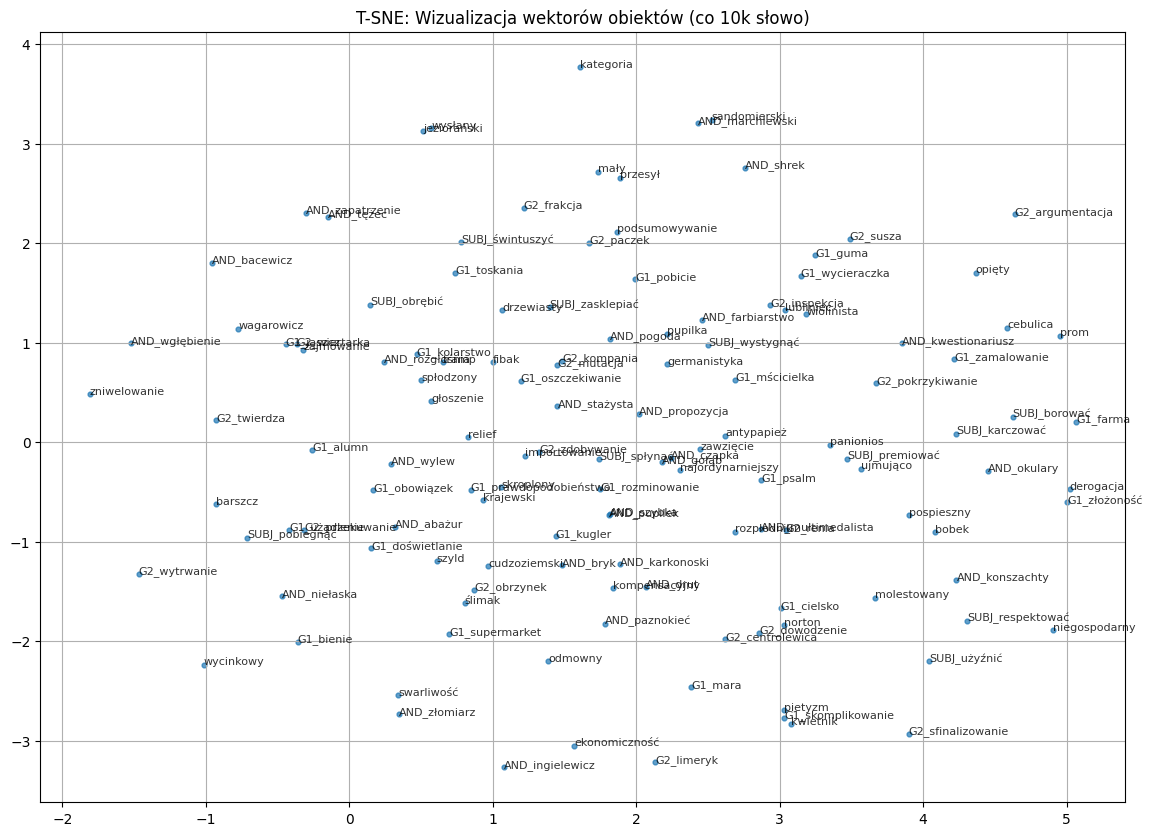

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

vectors = []
labels = []

output_path = '/content/drive/MyDrive/object_vectors.txt'

with open(output_path, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 2:
            continue
        word = parts[0]
        vec = list(map(float, parts[1:]))
        labels.append(word)
        vectors.append(vec)

step = 1000
selected_vectors = vectors[::step]
print(len(selected_vectors))
selected_labels = labels[::step]

selected_vectors = np.array(selected_vectors)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
reduced = tsne.fit_transform(selected_vectors)

plt.figure(figsize=(14, 10))
plt.scatter(reduced[:, 0], reduced[:, 1], s=12, alpha=0.7)

for i, label in enumerate(selected_labels):
    plt.annotate(label, (reduced[i, 0], reduced[i, 1]), fontsize=8, alpha=0.8)

plt.title("T-SNE: Wizualizacja wektorów obiektów (co 10k słowo)")
plt.grid(True)
plt.show()


## Task 2 [2p*]

Your task is to train the embeddings for Simple Wikipedia titles, using gensim library. As the example below shows, training is really simple:

```python
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")
```
*sentences* can be a list of list of tokens, you can also use *gensim.models.word2vec.LineSentence(source)* to create restartable iterator from file. At first, use [this file](https://drive.google.com/file/d/1H0ChgZjcbW7x3Gy_9RK0CoduP5M8WscP/view?usp=drive_link) containing such pairs of titles, that one article links to another.

We say that two titles are *related* if they both contain a word (or a word bigram) which is not very popular (it occurs only in several titles). Make this definition more precise, and create the corpora which contains pairs of related titles. Make a mixture of the original corpora, and the new one, then train title vectors again.

Compare these two approaches using similar code to the code from Task 1.

# Task 3 [3p]

Suppose that we have two languages: Upper and Lower. This is an example Upper sentence:

<pre>
THE QUICK BROWN FOX JUMPS OVER THE LAZY DOG.
</pre>

And this is its translation into Lower:

<pre>
the quick brown fox jumps over the lazy dog
</pre>

You have two corpora for these languages (with different sentences); see files [polish_lower](https://drive.google.com/file/d/1H1WMHpf3UXe2Q_QrhuvbxPTbsinvHIHr/view?usp=drive_link), [polish_upper](https://drive.google.com/file/d/1H5117jA6VKiGEizqu15ap6eWkDdbE02t/view?usp=drive_link) . Your task is to train word embedings for both languages together, so as to make embeddings of the words which are its translations as close as possible. But unfortunately, you have the budget which allows you to prepare the translation only for 1000 words (we call it D, you have to deside which words you want to be in D)

Prepare the corpora wich contains three kind of sentences:
* Upper corpus sentences
* Lower corpus sentences
* sentences derived from Upper/Lower corpus, modified using D

There are many possible ways of doing this, for instance this one (ROT13.COM: hfr rirel fragrapr sebz obgu pbecben gjvpr: jvgubhg nal zbqvsvpngvbaf, naq jvgu rirel jbeqf sebz Q ercynprq ol vgf genafyngvba)

We define the score for an Upper WORD as  $\frac{1}{p}$, where $p$ is a position of its translation in the list of **Lower** words most similar to WORD. For instance, when most similar words to DOG are:

<pre>
WOLF, CAT, WOLVES, LION, gopher, dog
</pre>

then the score for the word DOG is 0.5. Compute the average score separately for words from D, and for words out of D (hint: if the computation takes to much time do it for a random sample).

Present embedding using the PCA method or t-SNE. You can use sklearn or any other library for this.


In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0;

In [ ]:
!pip uninstall -y numpy
!pip install numpy
!pip install --upgrade --force-reinstall gensim

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 65.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.m

ModuleNotFoundError: No module named 'numpy.char'

# Task 4: Word Embeddings [4p]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Tasks
You will use word vectors pre-computed on a large dataset.
1. **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
2. **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

3. **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
4. **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

# Task 5: Language Model [5p]

Build a basic language model using a publicly available text dataset. You'll experiment with RNN-based architectures (Simple RNN, LSTM, GRU) to learn how they model sequences.

### **Part 1: Dataset Download & Preparation (1 point)**

**Tasks:**

* Download a publicly available dataset, e.g., *Alice’s Adventures in Wonderland* from Project Gutenberg.
  * Use requests or a dataset API like torchtext.datasets.
* Preprocess the text:
  * Lowercase, remove non-alphabetic characters.
  * Tokenize into words (use nltk or spaCy).
  * Build a vocabulary, keeping frequent words (e.g., top 10k).
* Use **pretrained word embeddings** (e.g., GloVe 100d or FastText):
  * Load with torchtext.vocab, gensim, or similar.
  * Initialize the embedding layer with pretrained vectors.


### **Part 2: Build a Recurrent Language Model (1 point)**

**Tasks:**

* Implement a word-level language model using:
  * Pretrained embedding layer (frozen or trainable).
  * A single-layer **Simple RNN**.
  * A fully connected output layer with softmax.

### **Part 3: Train the Model (1 point)**

**Tasks:**

* Use cross-entropy loss.
* Predict the next word from a sequence.
* Use teacher forcing and batching.
* Plot training loss over time.

### **Part 4: Generate Text (1 point)**

**Tasks:**

* Given a seed sequence, generate text of specified length.
* Use **temperature sampling** to vary creativity.
* Try different temperatures and compare.

### **Part 5: Evaluation & Reflection (1 point) -> W&B report**

**Tasks:**

* Evaluate model outputs: does it learn sentence structure?
* Reflect on limitations of the Simple RNN and its behavior on longer sequences.

### **Bonus Section (Up to +2 Points): Model Comparison**

Compare the performance of three models:


1. Simple RNN
2. LSTM
3. GRU

**Tasks:**

* Implement the same model architecture but switch out the recurrent layer.
* Train all three models under the same conditions.
* Record and compare:
  * Training time
  * Final loss
  * Generated text quality
* (Optional) Add dropout to recurrent layers and observe effects.
* Summarize findings in a table or chart.